## New User Recruitment - Identifying Potential Customers at Risk

In this project, we want to identify first time experience users who will make a booking within 2 days of interacting with the site. Users who does not make a reservation within 2 days are at risk of chooising another competitor. We can also custom target these users to improve Lead Velocity Rate.

Lead Velocity Rate is a SaaS metric defined to be how many users are you working on to converting to actual customers. 


This is important because, we want to convert these users who are at risk to actual customers. By correctly identifying which new users we are at risk of losing, companies like AirBnB can run personalized promotion (first user discounts) to convert these users to lower the risk of losing them to competitors. Vise versa, we want to identify key features which heavily influence first time users who initiates a booking. For example, we can re-direct campaign efforts and ads certain affiliate methods from this information.

Terminologies:
* User activation is when a user have started using the product, in our case - makes a booking on AirBnB.
* Lead Velocity Rate is the number of user you are working on to be converted to actual customers compared to previous month.
* User is someone who have interacted with the site.
* Potential Customers are users who are likely to be converted to be customers.

Data - We will use airbnb recruiting-new-user-bookings [dataset](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data) from kaggle competition for this case study.

An important design of this project is to determine who are at risk. This will be our target variable. In this case study, we will define users who had their first activity and did not make a booking within 2 days or less. If users fits the condition, they are at risk of going to a competitor.

* Design Reasoning: We chose 2 days threshold because as business, because after two days the user are likely to turn to other competitors for alternative options.

#### Data
* train_users.csv - the training set of users
* test_users.csv - the test set of users
* id: user id
* date_account_created: the date of account creation
* timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
* date_first_booking: date of first booking
* gender
* age
* signup_method
* signup_flow: the page a user came to signup up from
* language: international language preference
* affiliate_channel: what kind of paid marketing
* affiliate_provider: where the marketing is e.g. google, craigslist, other
* first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
* signup_app
* first_device_type
* first_browser
* country_destination: this is the target variable you are to predict

## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('train_users_2.csv')
test_df = pd.read_csv('test_users.csv')

In [3]:
train_df.shape, test_df.shape

((213451, 16), (62096, 15))

#### Remove the country_destination column from train_df and combine both train and test datasets

In [4]:
booking = pd.concat([train_df.drop('country_destination',1), test_df])
booking.shape

(275547, 15)

In [5]:
booking.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


#### We need to covnert the datetime columns to datetime objects

In [6]:
booking_time = booking.copy()
booking_time['date_account_created'] = pd.to_datetime(booking_time['date_account_created'].astype(str))
booking_time['timestamp_first_active'] = pd.to_datetime(booking_time['timestamp_first_active'].astype(str))
booking_time['date_first_booking'] = pd.to_datetime(booking_time['date_first_booking'].astype(str))

#### We want to create a column that calculates the time delta between account made and first activity

In [7]:
booking_time['time_delta_account_first'] = abs(booking_time['date_account_created'] - 
                                               booking_time['timestamp_first_active'])


We want to find all our users who made an account and had his/her first activity within 24 hours apart.

In [8]:
booking_time['serious_customer'] = [1 if time.days == 0  else 0 for time in 
                                    booking_time['time_delta_account_first']]
print(booking_time.shape)

(275547, 17)


In [9]:
booking_filter = booking_time[booking_time['serious_customer'] == 1]
print(booking_filter.shape)

(275376, 17)


In [10]:
#calculate the time between they first browse the website and they first booked a room
booking_delta = booking_filter.copy()
booking_delta['time_delta_book_activity'] = abs(booking_delta['date_first_booking'] - booking_delta['timestamp_first_active'])

Let's create our target variable column 'booker'
* 1 if the user books within 2 days
* 0 if the user does not book within 2 days

In [11]:
# User who book within 2 days or less are not at risk
days = 1 # This means within 2 days. 1 day and 15 hour is still considered 1 day
booking_delta['booker'] = [1 if (time.days <= days) else 0 for time in booking_delta['time_delta_book_activity']]

In [12]:
booking_delta.booker.value_counts()

0    232693
1     42683
Name: booker, dtype: int64

In [15]:
print(f'{booking_delta.booker.value_counts()[0]} users will not book a reversation within 2 days')
print(f'{booking_delta.booker.value_counts()[1]} users will book a reservation within 2 days')

232693 users will not book a reversation within 2 days
42683 users will book a reservation within 2 days


#### We can pickle this DataFrame for later

In [17]:
booking_delta.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'time_delta_account_first', 'serious_customer',
       'time_delta_book_activity', 'booker'],
      dtype='object')

In [18]:
# #Drop some columsn that will not be used
# cols_to_drop = ['id', 'date_account_created', 'timestamp_first_active','time_delta_account_first', 'serious_customer',
#                 'date_first_booking', 'time_delta_book_activity', 'serious_customer']
# booking_delta.drop(cols_to_drop, 1, inplace = True)

# booking_delta.to_pickle('booking.pkl')

## EDA

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Read pickled file
booking = pd.read_pickle('booking.pkl')

In [21]:
booking.columns

Index(['gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser', 'booker'],
      dtype='object')

#### Create helper function to visualize the relationship of all these features and our target

In [22]:
def count_booker(feature, data, size = 15):
    
    plt.figure(figsize = (10,6))
    sns.countplot(feature, data = data, 
                  hue = 'booker', palette = 'muted', 
                  order = data[feature].value_counts().index)
    
    plt.title(f'Number of Different {feature} by Booking', size = size + 5)
    plt.xlabel(f'{feature}',size = size)
    plt.ylabel('Count',size = size)

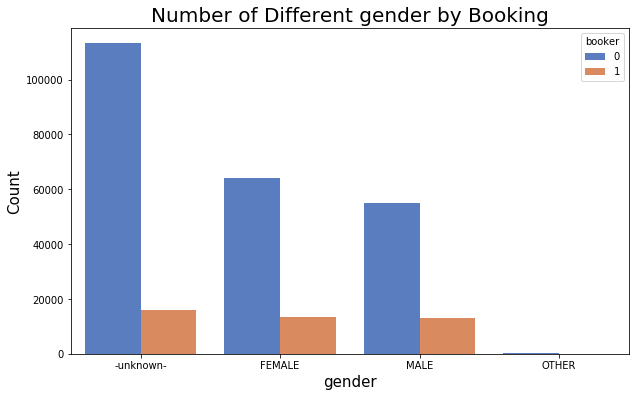

In [23]:
count_booker('gender', data = booking)

In [24]:
q25, q50, q75 = np.percentile(booking.age.dropna(), [25, 50, 75])

IQR = q75 - q25
min_age = q25 - 1.5 * IQR
max_age = q75 + 1.5 * IQR

print(min_age, max_age)

7.0 63.0


Let's filter out our dataset with age between age 18 and 70. You must be at least 18 years of age to sign up for AirBnB

In [25]:
booking_age_filter = ((booking.age > 18) & (booking.age < 70))
booking_age_filtered = booking[booking_age_filter]
booking_age_filtered.shape

(152820, 12)

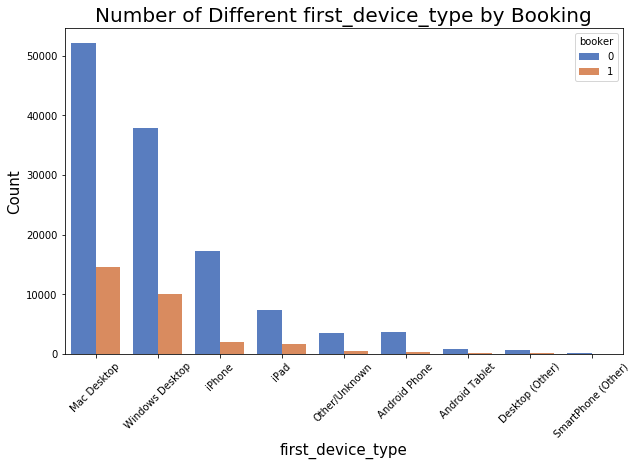

In [26]:
count_booker('first_device_type', data = booking_age_filtered)
plt.xticks(rotation=45);

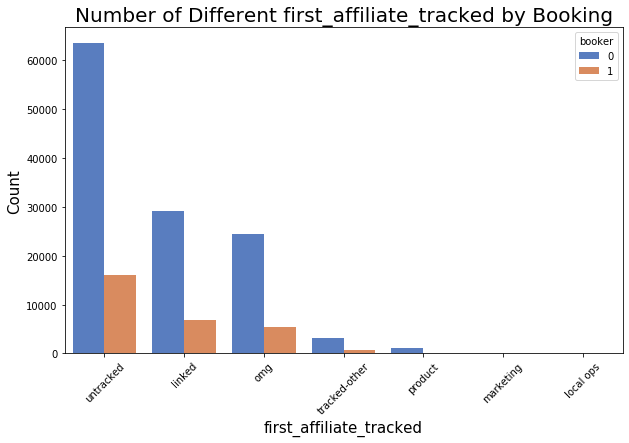

In [27]:
count_booker('first_affiliate_tracked', data = booking_age_filtered);
plt.xticks(rotation=45);

Let's group some of these smaller categories together and name it miscellaneous

In [28]:
# We will use the top 6 as 
main_provider = list(booking_age_filtered.affiliate_provider.value_counts().index[:6])
new_provider = [provider if provider in main_provider else 'miscellaneous' for provider in booking_age_filtered['affiliate_provider']]

In [29]:
booking_provider = booking_age_filtered.copy()
booking_provider['affiliate_provider'] = new_provider

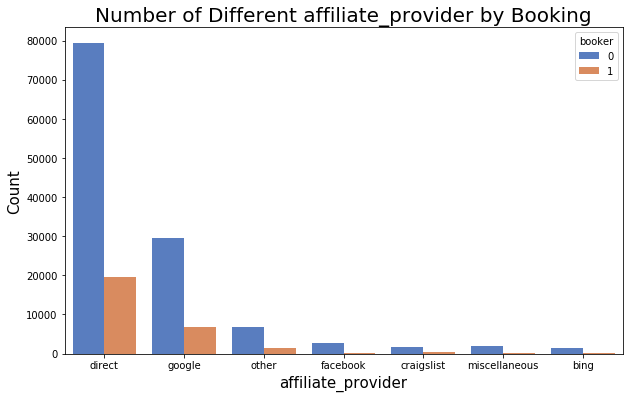

In [30]:
count_booker('affiliate_provider', data = booking_provider)

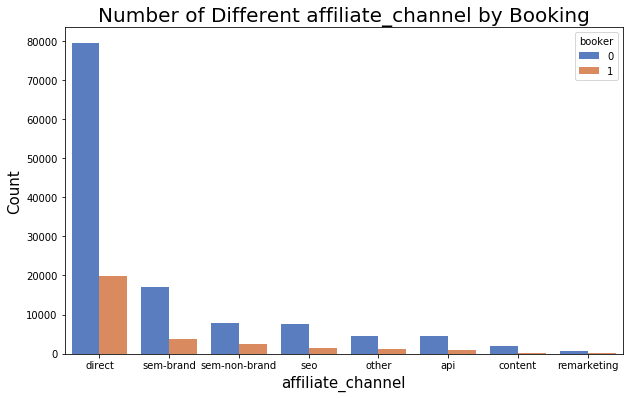

In [31]:
count_booker('affiliate_channel', data = booking_provider)

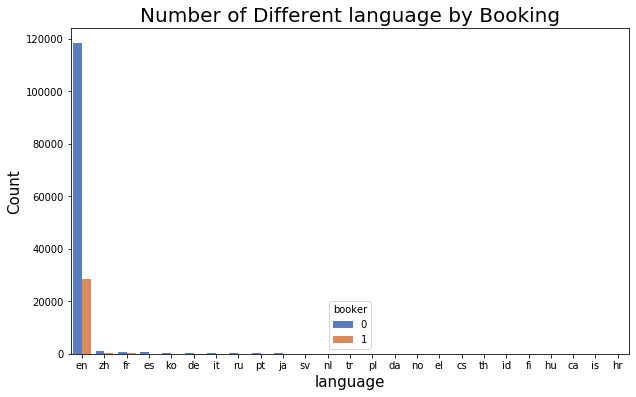

In [32]:
count_booker('language', data = booking_provider)

Let's put all the other languages under 'other' if not en

In [33]:
booking_provider['language'] = [x if x == 'en' else 'other' for x in booking_provider['language']]

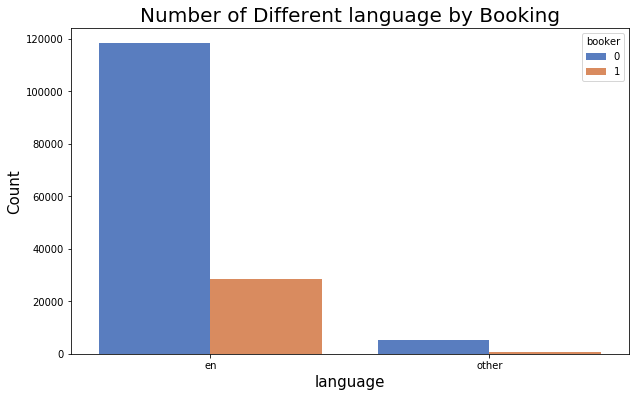

In [34]:
count_booker('language', data = booking_provider)

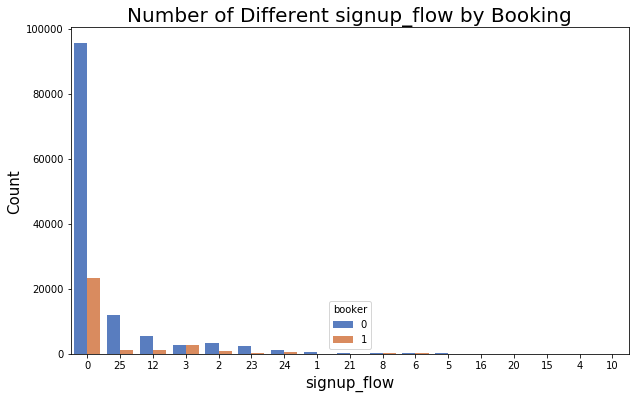

In [35]:
count_booker('signup_flow', data = booking_provider)

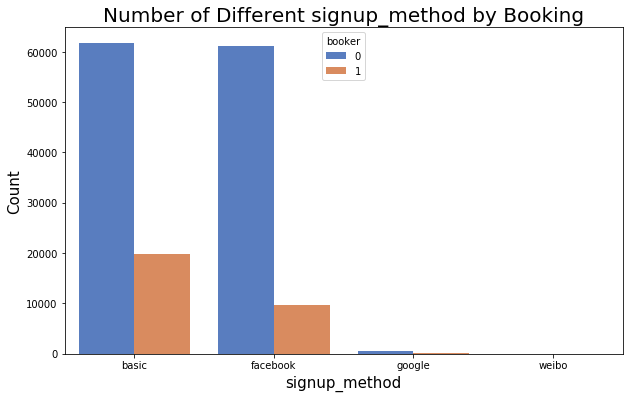

In [36]:
count_booker('signup_method', data = booking_provider)

In [37]:
booking_provider.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,booker
6,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,0
7,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,0
8,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,0
9,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,1
10,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,1


#### Pickle Checkpoint

In [38]:
# booking_provider.to_pickle('filtered_booking.pkl')

In [78]:
booking_df = pd.read_pickle('filtered_booking.pkl')